# This is a PyBaMM test.
I want to create some PyBaMM data. Synthetic data.

In [1]:
# import libraries
import os
import time
import pybamm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/lucas/anaconda3/envs/tf_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


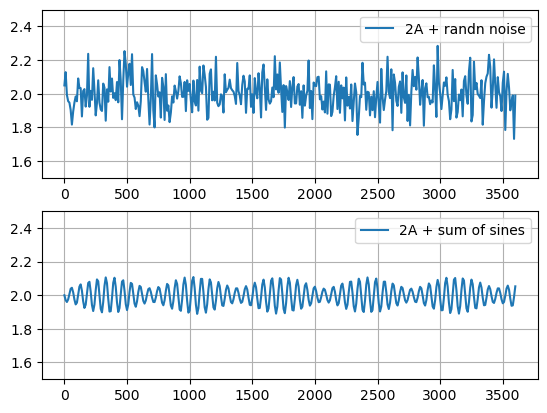

In [2]:
def generate_data_randn(avg, stddev, t_step=10, max_time=3600):
    # this is it
    time = np.arange(0, max_time+t_step, t_step)
    out  = (np.ones_like(time) * avg) + (np.random.randn(*time.shape) * stddev)

    return pybamm.Interpolant(time, out, pybamm.t)

def generate_data_sum_sin(avg, max_amp, num_sines=3, t_step=10, max_time=3600):
    max_freq = 1/4/t_step
    time = np.arange(0, max_time+t_step, t_step)
    out  = np.ones_like(time, dtype=np.float64) * avg
    for i in range(num_sines):
        out += np.sin(2*np.pi*np.random.rand()*max_freq*time) * (2*np.random.rand()-1) * max_amp

    return pybamm.Interpolant(time, out, pybamm.t)


# demo interpolant data generation functions
curr_interpolant_rand = generate_data_randn(2., 0.1)
curr_interpolant_sine = generate_data_sum_sin(2., 0.15)

fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(curr_interpolant_rand.x[0], curr_interpolant_rand.y, label="2A + randn noise")
ax1.set_ylim(1.5, 2.5)
ax1.grid(True)
ax1.legend()

ax2.plot(curr_interpolant_sine.x[0], curr_interpolant_sine.y, label="2A + sum of sines")
ax2.set_ylim(1.5, 2.5)
ax2.grid(True)
ax2.legend()

plt.show()

In [3]:
def init_pybamm_model():
    param_values = pybamm.ParameterValues("Chen2020")
    return (pybamm.lithium_ion.DFN({"thermal":"lumped"}),
           param_values,
           param_values["Nominal cell capacity [A.h]"])


def generate_simulation(model, parameter_values, cell_capacity, crate_avg=1, crate_dx_pc=0.2, temp_avg=300.0, temp_dx=10.0):
    parameter_values["Current function [A]"] = generate_data_sum_sin( cell_capacity*crate_avg, cell_capacity*crate_avg*crate_dx_pc )
    parameter_values["Ambient temperature [K]"] = generate_data_sum_sin( temp_avg, temp_dx )
    parameter_values["Initial temperature [K]"] = temp_avg

    casSolver = pybamm.CasadiSolver(mode='safe')
    return pybamm.Simulation(model, parameter_values=parameter_values, solver=casSolver)

In [4]:
model, param_vals, cell_capacity = init_pybamm_model()
simul = generate_simulation(model, param_vals, cell_capacity,
                            crate_avg=1, crate_dx_pc=0.2, temp_avg=300.0, temp_dx=10.0)
simul.solve(initial_soc = 0.95)

In [5]:
output_vars = ["Current [A]", "Voltage [V]", "X-averaged cell temperature [K]", "Ambient temperature [K]"]
simul.plot(output_vars)

interactive(children=(FloatSlider(value=0.0, description='t', max=3413.3665420223715, step=34.133665420223714)…

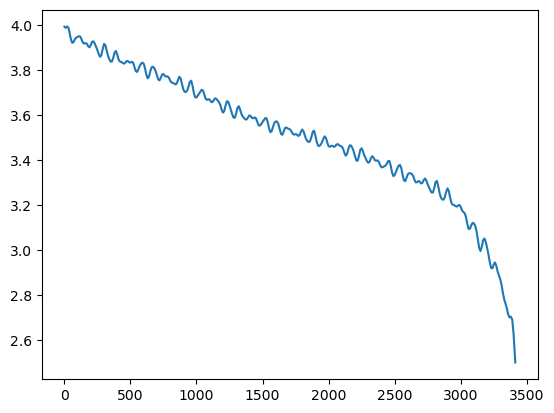

In [6]:
def transfer_sol_pandas(solution):
    return pd.DataFrame(data={
        "Time_s": solution["Time [s]"].entries,
        "Current_A": solution["Current [A]"].entries,
        "Temperature_K": solution["Ambient temperature [K]"].entries,
        "Voltage_V": solution["Voltage [V]"].entries,
        "SoC_pc": solution["R-averaged negative particle stoichiometry"].entries.mean(axis=0)
    })

df_sol = transfer_sol_pandas(simul.solution)
df_sol.head()
plt.plot(df_sol["Time_s"], df_sol["Voltage_V"])

In [7]:
def generate_discharge_data(crate_max_lim, crate_min_lim, crate_dx,
                            temp_max_lim, temp_min_lim, temp_dx,
                            soc_max_lim, soc_min_lim,
                            base_file_name):
    # thing
    np.random.seed(int(time.time()))
    avg_crate = crate_min_lim + (crate_max_lim-crate_min_lim) * np.random.rand()
    avg_temp = temp_min_lim + (temp_max_lim-temp_min_lim) * np.random.rand()
    init_soc = soc_min_lim + (soc_max_lim-soc_min_lim) * np.random.rand()

    file_name = f"{base_file_name}__initSoC{100*init_soc:.0f}_temp{avg_temp:.0f}_cRate{100*avg_crate:.0f}.csv"
    print(file_name)

    model, param_vals, cell_capacity = init_pybamm_model()
    simul = generate_simulation(model, param_vals, cell_capacity,
                                crate_avg = avg_crate , crate_dx_pc = crate_dx, 
                                temp_avg= avg_temp, temp_dx = temp_dx)
    
    simul.solve(initial_soc = init_soc)

    pandas_sol = transfer_sol_pandas(simul.solution)
    return pandas_sol, file_name

In [ ]:
N = 6
for i in range(N):
    x, f = generate_discharge_data(1.5, 0.5, 0, 315, 280, 0, 0.95, 0.60, "discharge_noFlux__")
    x.to_csv(os.path.join("data", "pybamm", f), index=False)
    print(f"{1+i}/{N} completed")

discharge_noFlux____initSoC95_temp293_cRate142.csv


At t = 126.106 and h = 2.7491e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 126.106 and h = 1.63714e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 126.106 and h = 1.43282e-13, the corrector convergence failed repeatedly or with |h| = hmin.


1/6 completed
discharge_noFlux____initSoC63_temp299_cRate115.csv


At t = 298.341 and h = 3.9114e-14, the corrector convergence failed repeatedly or with |h| = hmin.


2/6 completed
discharge_noFlux____initSoC82_temp283_cRate107.csv


At t = 524.611 and h = 8.70318e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 234.611 and h = 9.73191e-19, the corrector convergence failed repeatedly or with |h| = hmin.


3/6 completed
discharge_noFlux____initSoC79_temp290_cRate100.csv
4/6 completed
discharge_noFlux____initSoC76_temp292_cRate112.csv


At t = 209.213 and h = 7.25021e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 209.213 and h = 1.02088e-14, the corrector convergence failed repeatedly or with |h| = hmin.


5/6 completed
discharge_noFlux____initSoC69_temp284_cRate82.csv


At t = 244.188 and h = 7.55133e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 244.188 and h = 8.60223e-15, the corrector convergence failed repeatedly or with |h| = hmin.


6/6 completed
